In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.neural_network import MLPRegressor

RANDOM_STATE = 42

# Load the dataset
file_path = '/content/turbofan_engine_degradation.csv'
df = pd.read_csv(file_path)

# Step 1: Feature Engineering
df['cycle_ratio'] = df['time_in_cycles'] / df.groupby('unit_number')['time_in_cycles'].transform('max')
df['pressure_rpm_interaction'] = df['pressure_sensor'] * df['rpm_sensor']
df['vibration_fuel_flow_interaction'] = df['vibration_sensor'] * df['fuel_flow_sensor']

# Add lag features
sensor_columns = ['temperature_sensor', 'pressure_sensor', 'vibration_sensor', 'rpm_sensor',
                  'fuel_flow_sensor', 'oil_pressure_sensor', 'coolant_temp_sensor',
                  'hydraulic_pressure_sensor', 'exhaust_temp_sensor']
for sensor in sensor_columns:
    df[f'{sensor}_lag1'] = df.groupby('unit_number')[sensor].shift(1).fillna(df[sensor])

# Prepare features and target variable (RUL)
X = df.drop(columns=['RUL', 'unit_number', 'time_in_cycles'])
y = df['RUL']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Random Forest with reduced n_estimators
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=RANDOM_STATE)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

# Step 6: XGBoost with reduced n_estimators and learning rate
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=7, random_state=RANDOM_STATE)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")

# Step 7: Train an LSTM model with increased epochs and units
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=64, validation_split=0.2, verbose=2)  # Increased epochs

# Evaluate LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
lstm_r2 = r2_score(y_test, y_pred_lstm)
print(f"LSTM RMSE: {lstm_rmse:.2f}, R²: {lstm_r2:.2f}")

# Step 8: Train a Feedforward NN (MLP) with increased max_iter for convergence
mlp_regressor = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=RANDOM_STATE)  # Increased max_iter
mlp_regressor.fit(X_train_scaled, y_train)

# Evaluate Feedforward NN
y_pred_mlp = mlp_regressor.predict(X_test_scaled)
mlp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mlp_r2 = r2_score(y_test, y_pred_mlp)
print(f"Feedforward NN RMSE: {mlp_rmse:.2f}, R²: {mlp_r2:.2f}")

# Step 9: Stacking all four models with cross-validation
stacking_train = np.column_stack([y_pred_rf, y_pred_xgb, y_pred_lstm, y_pred_mlp])
stacking_test = np.column_stack([rf.predict(X_test_scaled),
                                 xgb.predict(X_test_scaled),
                                 lstm_model.predict(X_test_lstm).flatten(),
                                 mlp_regressor.predict(X_test_scaled)])

# Random Forest as the stacking model with increased complexity
stacking_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_STATE)

# Perform cross-validation
cv_scores = cross_val_score(stacking_model, stacking_train, y_test, cv=5, scoring='r2')
print(f"Cross-validated R² Scores: {cv_scores}")
print(f"Mean Cross-validated R²: {cv_scores.mean():.2f}")

# Fit and evaluate the stacked model
stacking_model.fit(stacking_train, y_test)
stacked_predictions = stacking_model.predict(stacking_test)
stacked_rmse = np.sqrt(mean_squared_error(y_test, stacked_predictions))
stacked_r2 = r2_score(y_test, stacked_predictions)
print(f"Cross-validated Stacked Model RMSE: {stacked_rmse:.2f}")
print(f"Cross-validated Stacked Model R²: {stacked_r2:.2f}")


Random Forest RMSE: 30.93, R²: 0.79
XGBoost RMSE: 31.10, R²: 0.79
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 6s - 37ms/step - loss: 13090.5293 - val_loss: 12553.0439
Epoch 2/30
164/164 - 1s - 4ms/step - loss: 11557.5420 - val_loss: 11173.9902
Epoch 3/30
164/164 - 1s - 8ms/step - loss: 10477.9443 - val_loss: 10378.3320
Epoch 4/30
164/164 - 1s - 4ms/step - loss: 9788.8291 - val_loss: 9741.7520
Epoch 5/30
164/164 - 1s - 4ms/step - loss: 9185.7646 - val_loss: 9184.6611
Epoch 6/30
164/164 - 1s - 8ms/step - loss: 8657.4307 - val_loss: 8676.6357
Epoch 7/30
164/164 - 1s - 8ms/step - loss: 8165.8149 - val_loss: 8183.2217
Epoch 8/30
164/164 - 1s - 7ms/step - loss: 7683.4331 - val_loss: 7673.4141
Epoch 9/30
164/164 - 2s - 10ms/step - loss: 7217.4058 - val_loss: 7235.6714
Epoch 10/30
164/164 - 1s - 8ms/step - loss: 6814.7202 - val_loss: 6830.9175
Epoch 11/30
164/164 - 1s - 7ms/step - loss: 6425.9170 - val_loss: 6453.3379
Epoch 12/30
164/164 - 1s - 4ms/step - loss: 6071.4375 - val_loss: 6101.7637
Epoch 13/30
164/164 - 1s - 4ms/step - loss: 5735.1719 - val_loss: 5771.4351
Epoch 14/30
164/164 - 1s

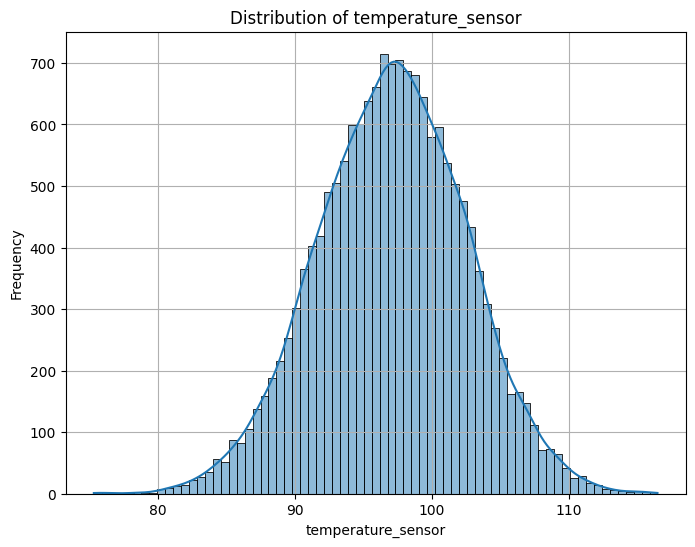

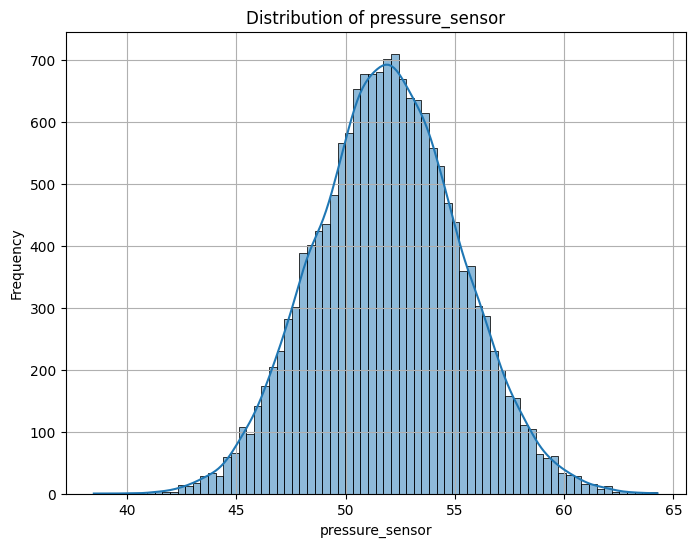

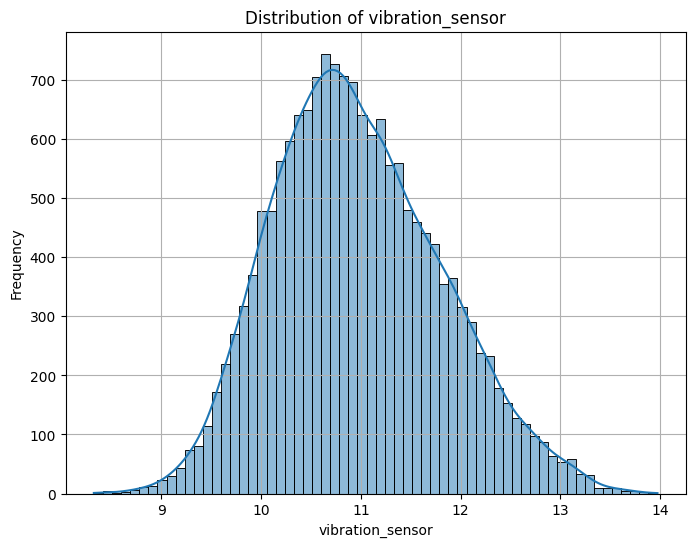

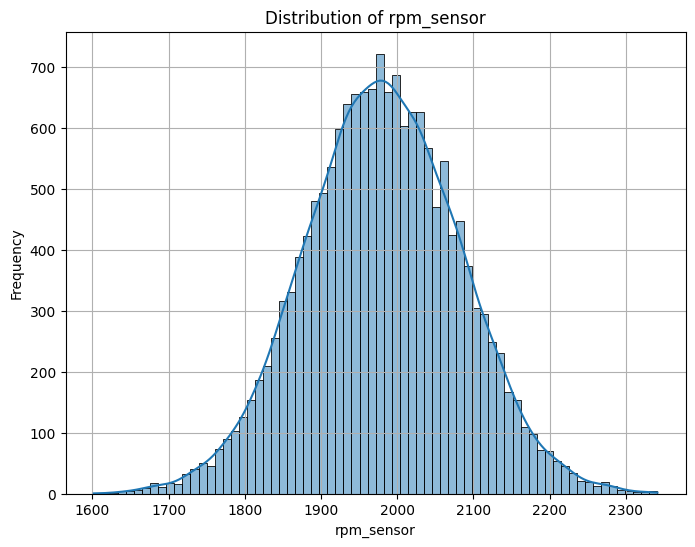

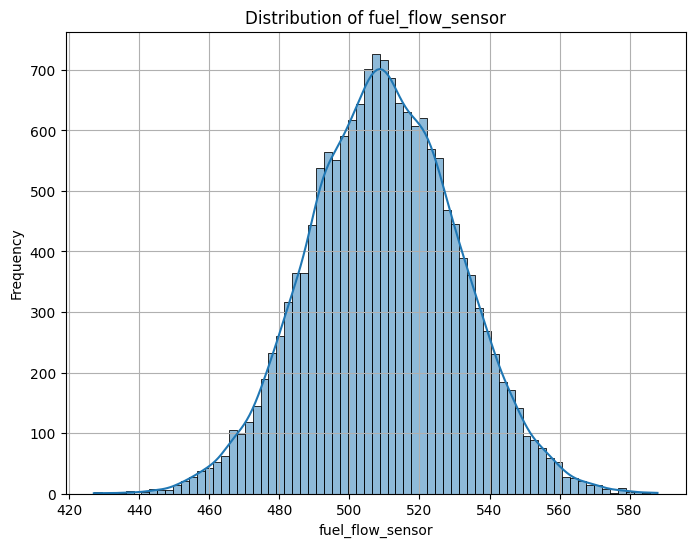

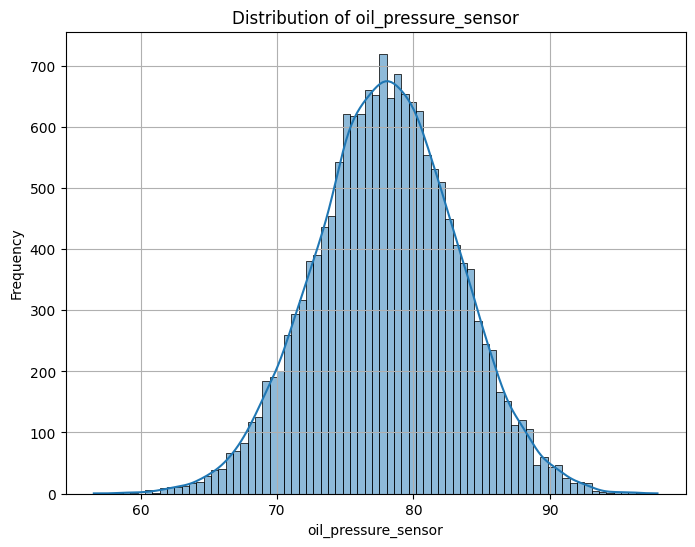

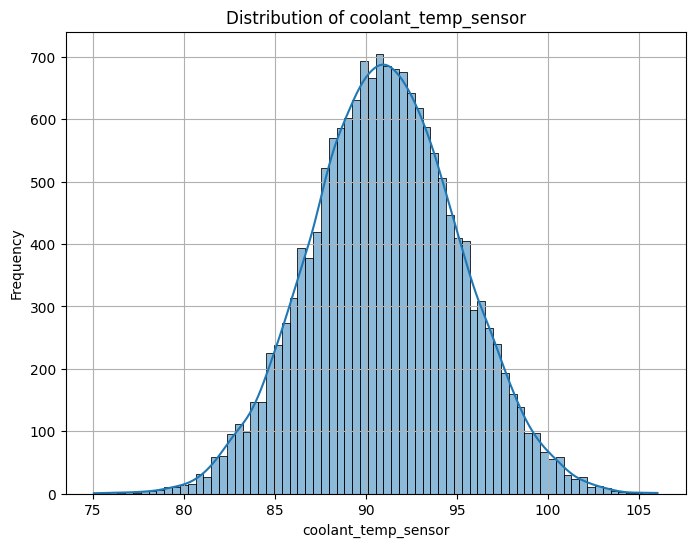

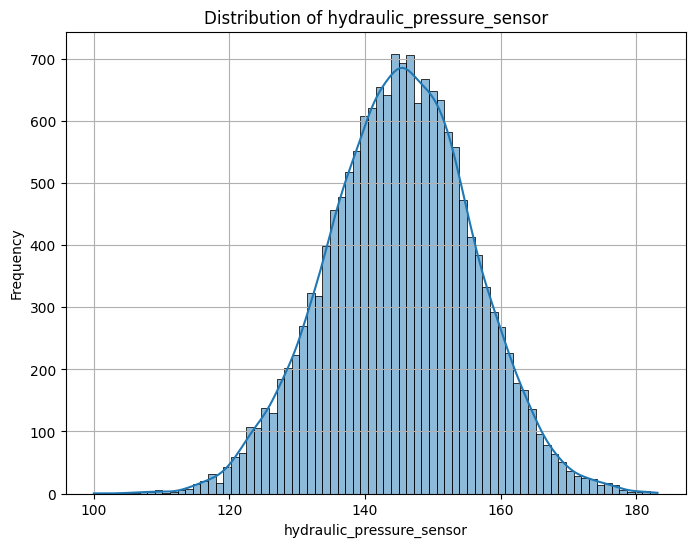

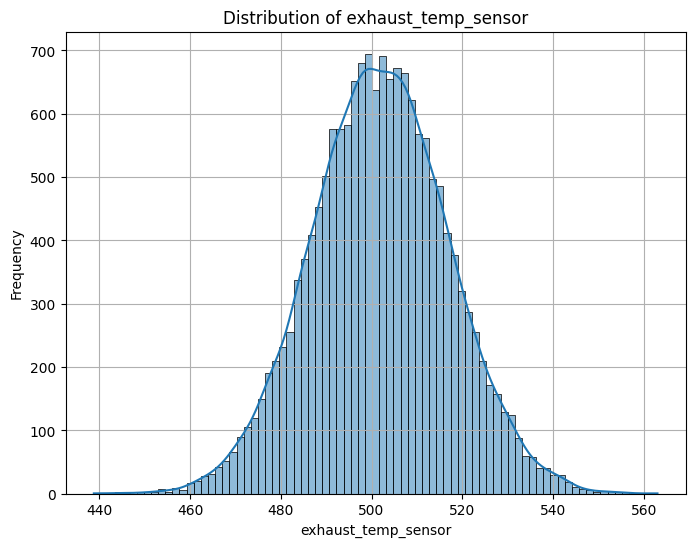

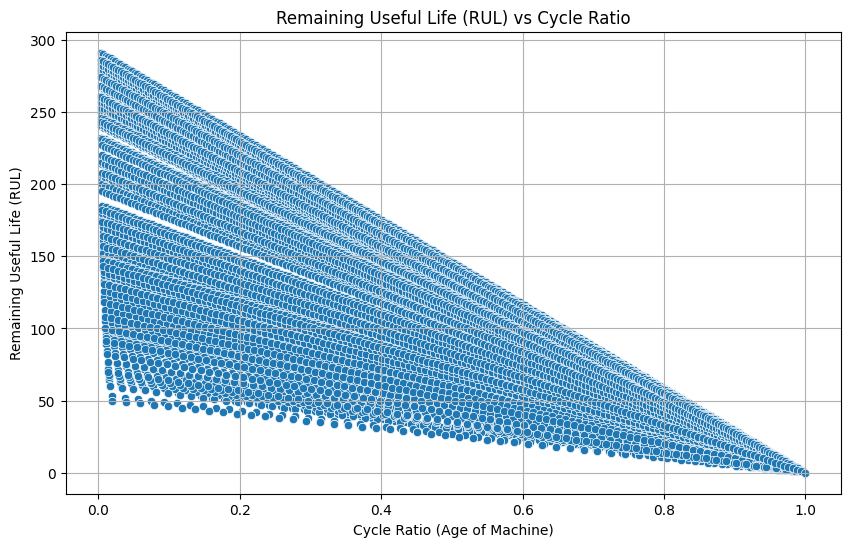

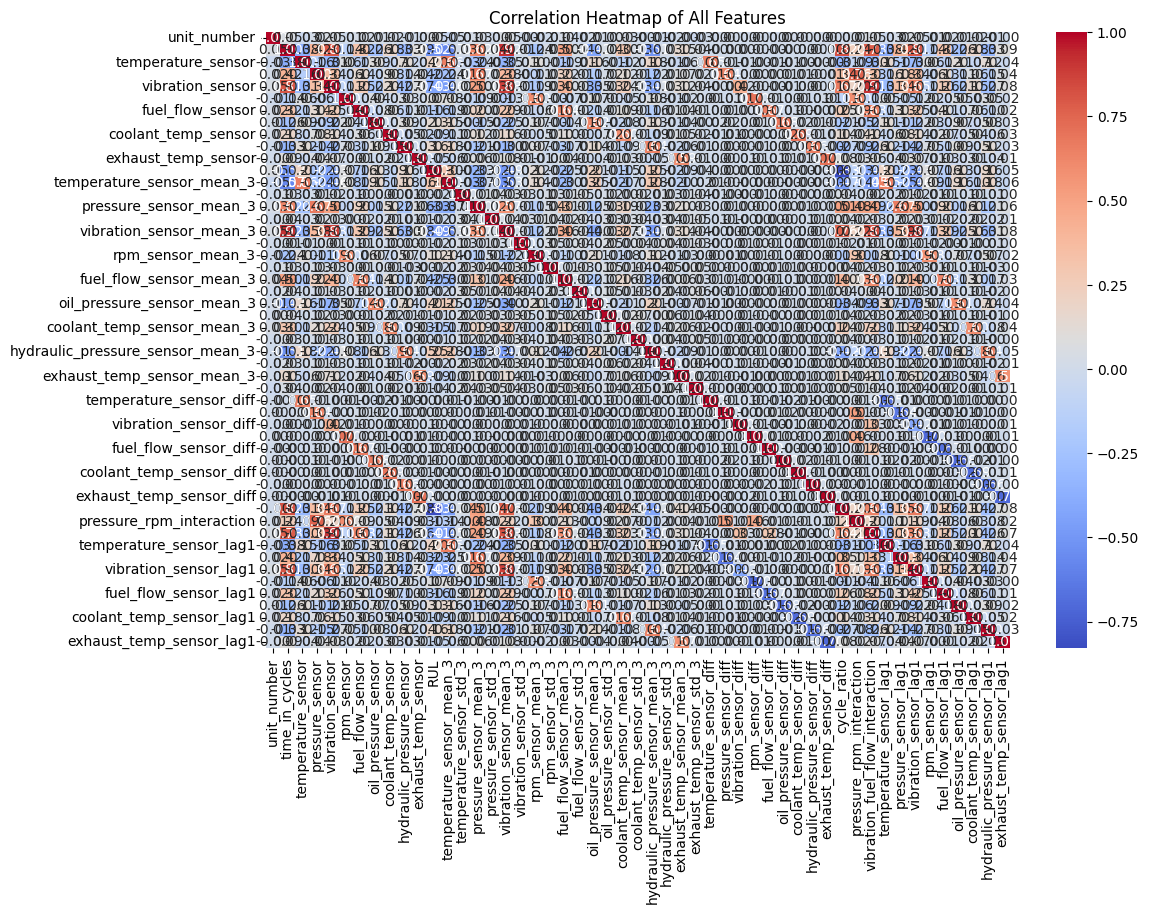

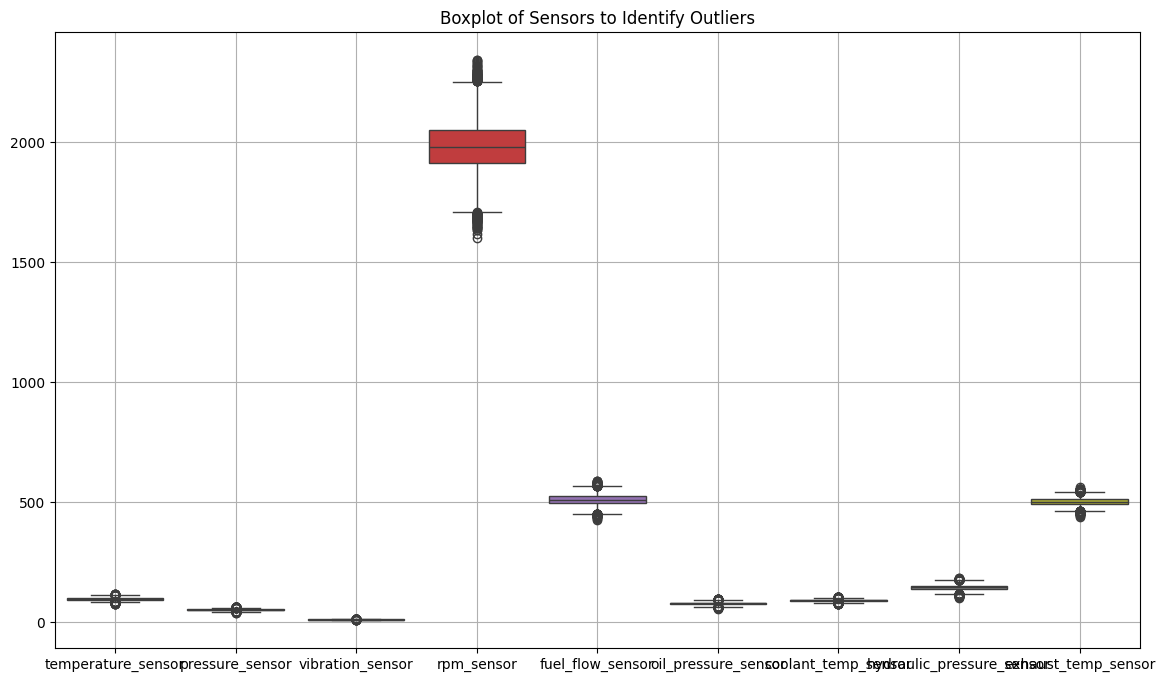

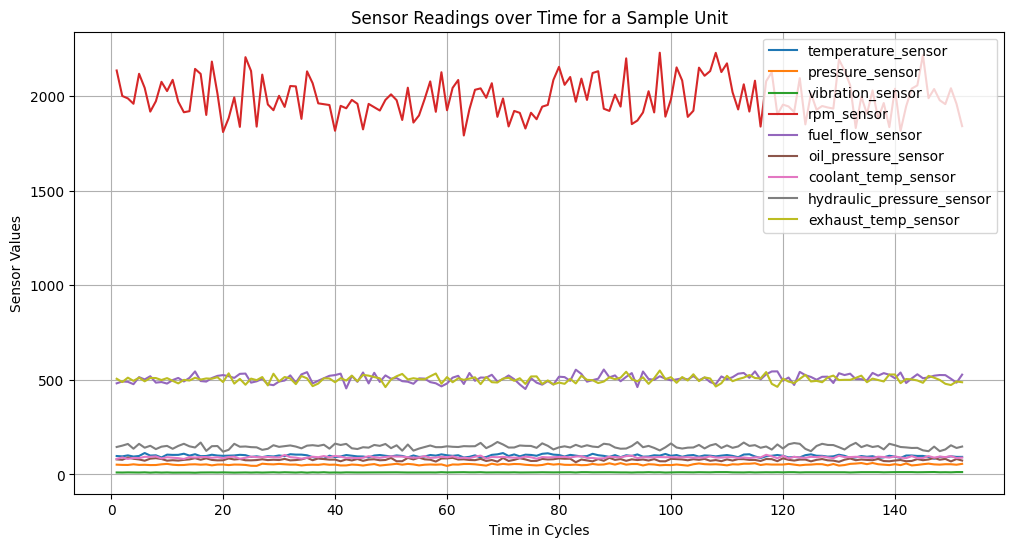

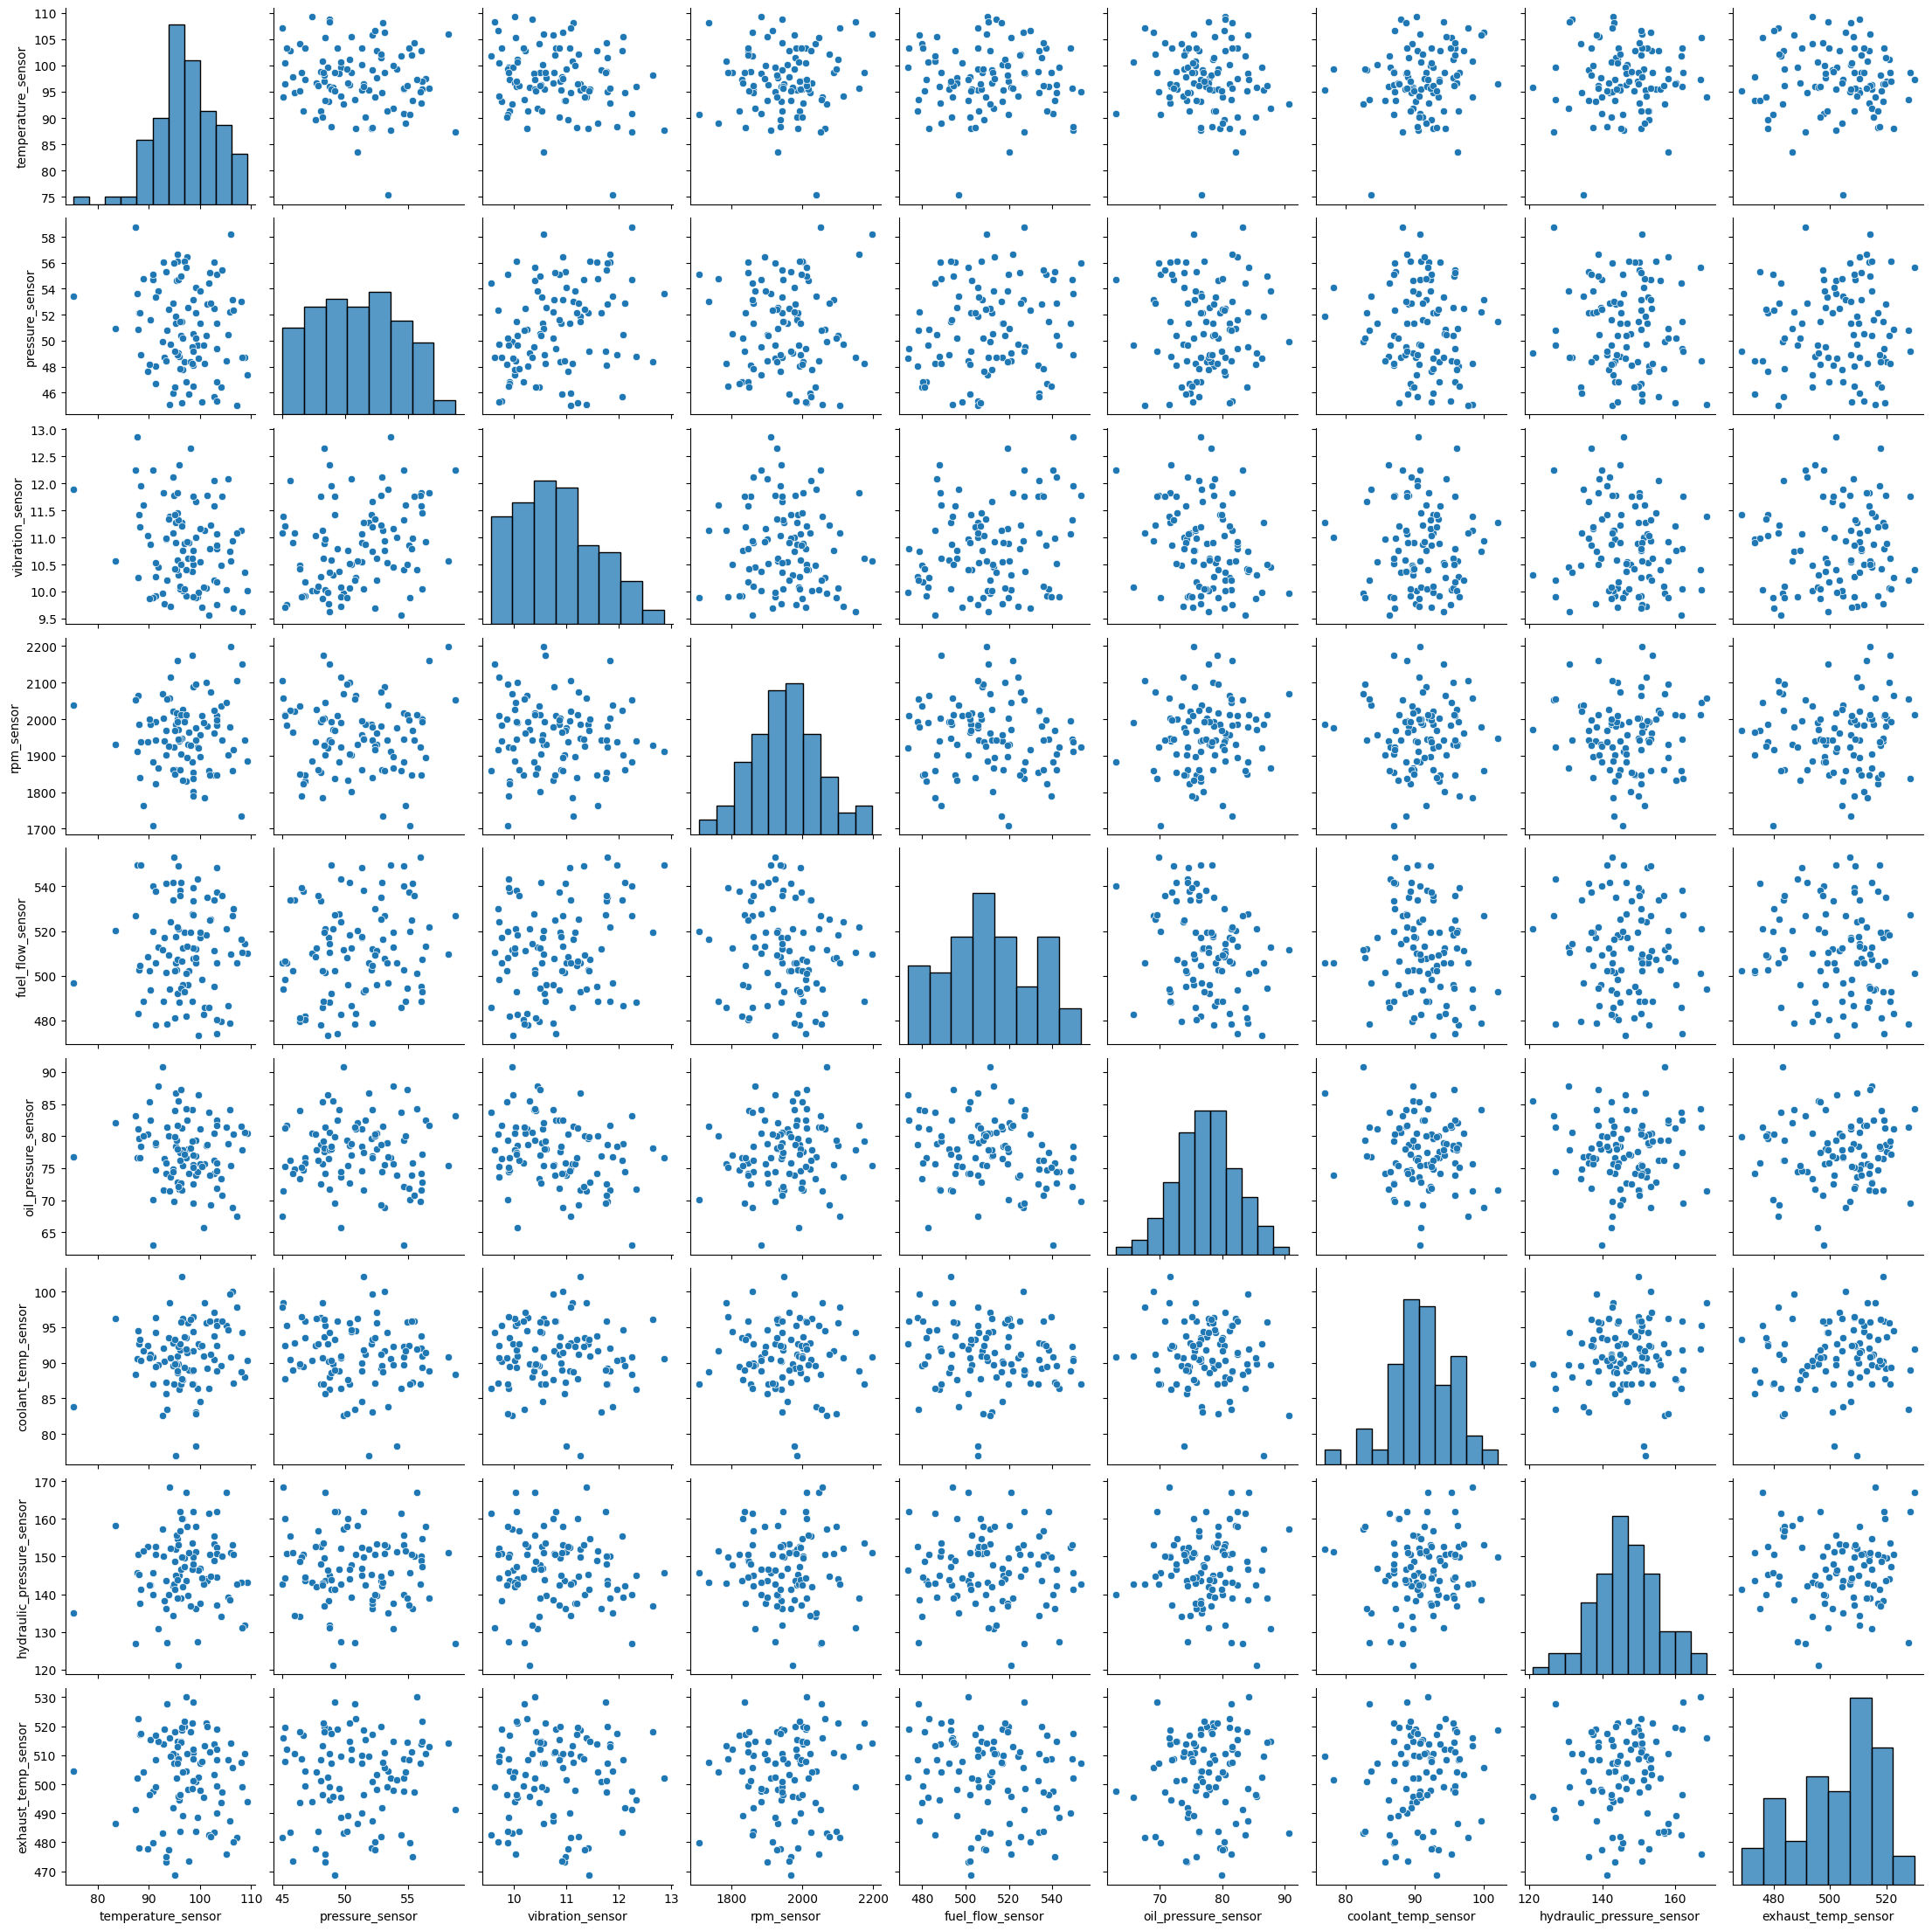

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sensor_columns = ['temperature_sensor', 'pressure_sensor', 'vibration_sensor', 'rpm_sensor',
                  'fuel_flow_sensor', 'oil_pressure_sensor', 'coolant_temp_sensor',
                  'hydraulic_pressure_sensor', 'exhaust_temp_sensor']

for sensor in sensor_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[sensor], kde=True)
    plt.title(f'Distribution of {sensor}')
    plt.xlabel(sensor)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['cycle_ratio'], y=df['RUL'])
plt.title('Remaining Useful Life (RUL) vs Cycle Ratio')
plt.xlabel('Cycle Ratio (Age of Machine)')
plt.ylabel('Remaining Useful Life (RUL)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of All Features')
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(data=df[sensor_columns])
plt.title('Boxplot of Sensors to Identify Outliers')
plt.grid(True)
plt.show()

unit_sample = df[df['unit_number'] == df['unit_number'].unique()[0]]
plt.figure(figsize=(12, 6))
for sensor in sensor_columns:
    plt.plot(unit_sample['time_in_cycles'], unit_sample[sensor], label=sensor)

plt.title('Sensor Readings over Time for a Sample Unit')
plt.xlabel('Time in Cycles')
plt.ylabel('Sensor Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

sns.pairplot(df[sensor_columns].sample(100))
plt.show()
